# N-Point Surface Simulations in TVB

(by analogy with Jirsa '2-point' connections)

## Notebook Setup

Define some variables

In [1]:
outdir = '/tmp/n-point_tvb_surface_sims'
!mkdir -p $outdir

import os
tvb_folder = os.path.abspath('../../../../../Code/libraries_of_others/github')
ctx_file = tvb_folder + '/tvb-data/tvb_data/surfaceData/cortex_16384.zip'


Importage

In [2]:
import os,sys,glob,numpy as np,pandas as pd
from copy import deepcopy

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

sys.path += [tvb_folder + '/' + t for t in ['tvb-library', 'tvb-data']]
from tvb.simulator.lab import *
from tvb.datatypes.region_mapping import RegionMapping
from tvb.datatypes.cortex import Cortex

from nilearn.plotting import plot_surf

2019-10-21 19:44:27,866 - WARNING - tvb.simulator.common - psutil module not available: no warnings will be issued when a
    simulation may require more memory than available
   INFO  log level set to INFO
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor.state_variable_range = Final(field_type=<class 'dict'>, default={'x1': array([-2.,  1.]), 'y1': array([-20.,   2.]), 'z': array([2., 5.]), 'x2': array([-2.,  0.]), 'y2': array([0., 2.]), 'g': array([-1.,  1.])}, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.epileptor.Epileptor2D.tt = NArray(label='tt', dtype=float64, default=array([1.]), dim_names=(), ndim=None, required=True)
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor2D.state_variable_range = Final(field

WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.stefanescu_jirsa.ReducedSetFitzHughNagumo.state_variable_range = Final(field_type=<class 'dict'>, default={'xi': array([-4.,  4.]), 'eta': array([-3.,  3.]), 'alpha': array([-4.,  4.]), 'beta': array([-3.,  3.])}, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindmarshRose.a = NArray(label=':math:`a`', dtype=float64, default=array([1.]), dim_names=(), ndim=None, required=True)
WARNING  default contains values out of the declared domain. Ex 3.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindmarshRose.b = NArray(label=':math:`b`', dtype=float64, default=array([3.]), dim_names=(), ndim=None, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindma

/nethome/kcni/jgriffiths/Software/miniconda3/envs/jupyter_py3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Go to output dir

In [3]:
os.chdir(outdir)

Ok, let's get cracking...

In [4]:
origctx = cortex.Cortex.from_file(ctx_file)
origctx.configure()

origconn = connectivity.Connectivity.from_file('connectivity_76.zip')
origconn.configure()

WARNING  File 'hemispheres' not found in ZIP.


In [5]:
lA1_nodenum = 38
rA1_nodenum = 0
rA1lA1_nodenums = np.array([rA1_nodenum,lA1_nodenum])

#newmat = np.zeros_like(conn.weights)
#newmat[rA1_nodenum,lA1_nodenum] = 3
#newmat[lA1_nodenum,rA1_nodenum] = 3

newmat = np.array([[0,1],[1,0]])
newconn = connectivity.Connectivity()
newconn.weights = newmat
newconn.region_labels = origconn.region_labels[rA1lA1_nodenums]
newconn.centres = origconn.centres[rA1lA1_nodenums]
newconn.cortical = origconn.cortical[rA1lA1_nodenums]
newconn.hemispheres = origconn.hemispheres[rA1lA1_nodenums]
newconn.tract_lengths = origconn.tract_lengths[rA1lA1_nodenums,:][:,rA1lA1_nodenums]
newconn.configure()

lA1_rmidxs_orig = np.nonzero(origctx.region_mapping==lA1_nodenum)[0]
rA1_rmidxs_orig = np.nonzero(origctx.region_mapping==rA1_nodenum)[0]

In [6]:
alltris_in_lA1_idxs_orig = []
alltris_in_rA1_idxs_orig = []

for l_it,l in enumerate(origctx.triangles):
  if (l[0] in lA1_rmidxs_orig and l[1] in lA1_rmidxs_orig and l[2] in lA1_rmidxs_orig): 
    alltris_in_lA1_idxs_orig.append(l_it)
    
  if (l[0] in rA1_rmidxs_orig and l[1] in rA1_rmidxs_orig and l[2] in rA1_rmidxs_orig): 
    alltris_in_rA1_idxs_orig.append(l_it)    
    
    

In [7]:
# Tests: these should error if any of the triangle values are not in the 'alltris' arrays 

assert len([l for l in origctx.triangles[alltris_in_lA1_idxs_orig].ravel() if l not in lA1_rmidxs_orig]) == 0
assert len([l for l in origctx.triangles[alltris_in_rA1_idxs_orig].ravel() if l not in rA1_rmidxs_orig]) == 0


newtris = origctx.triangles[alltris_in_rA1_idxs_orig+alltris_in_lA1_idxs_orig]
newrm = np.array([rA1_nodenum for r in rA1_rmidxs_orig] + [lA1_nodenum for l in lA1_rmidxs_orig])
newrm_v2 = newrm.copy()
newrm_v2[newrm==38] = 1

newvtxids_un = np.unique(newtris)
newvtcs = origctx.vertices[newvtxids_un]
newvtcs_key = {k: k_it for k_it,k in enumerate(newvtxids_un)}
newtris_renamed = np.array([[newvtcs_key[kk] for kk in k] for k in newtris])


new_vertex_triangles = [origctx.vertex_triangles[r] for r in newvtxids_un]

In [8]:
# test: newtris_renamed should pick out same array from newvtcs as newtris picks out from orig vtcs
assert len(np.nonzero((newvtcs[newtris_renamed].ravel() == origctx.vertices[newtris].ravel())==False)[0]) == 0

In [9]:
newctx = Cortex()
#newctx = cortex.CorticalSurface()
newctx.coupling_strength = np.array([2**-10])

newctx.vertices = newvtcs
newctx.triangles = newtris_renamed
#newctx.region_mapping_data = newrm
#setattr(newctx,'region_mapping', newrm)

#tmprm = RegionMappingData()
tmprm = RegionMapping()
tmprm.array_data = newrm_v2
newctx.region_mapping_data = tmprm
#newctx.vertex_triangles = new_vertex_triangles
#newctx.vertex_normals = origctx.vertex_normals[newvtxids_un]
newctx.configure()

model = models.Generic2dOscillator()
solver = integrators.HeunStochastic()
#cpl = coupling.Linear(a=0.1)
cpl = coupling.Linear(a=np.array([0.1]))
mons = (monitors.TemporalAverage(period=2**-2),)


#Initialise Simulator -- Model, Connectivity, Integrator, Monitors, and surface.
sim = simulator.Simulator(model = model, connectivity = newconn,
                          coupling = cpl,
                          integrator = solver,monitors = mons,
                          surface = newctx)
sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity
coupling,Linear
initial_conditions,None
integrator,HeunStochastic
model,Generic2dOscillator
monitors,"(,)"
simulation_length,1000.0
stimulus,None


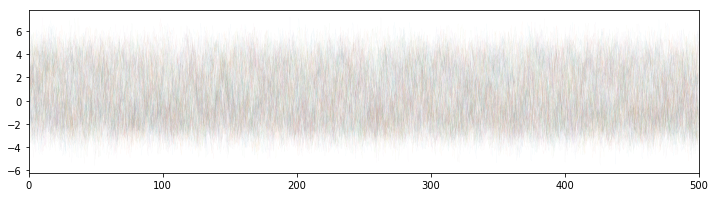

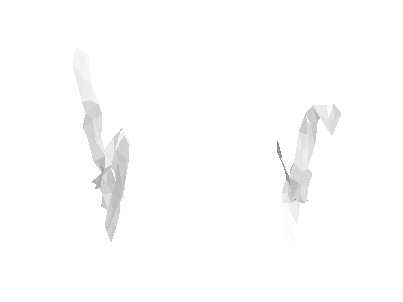

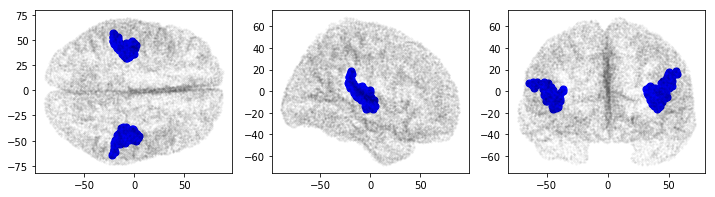

In [10]:
res = sim.run(simulation_length=500)

tavg_time,tavg_dat = res[0]
df_tavg = pd.DataFrame(np.squeeze(tavg_dat),index=tavg_time)


df_tavg.plot(legend=False,figsize=(12,3),linewidth=0.01)


ax = plot_surf([newctx.vertices,newctx.triangles]);


fig, ax =plt.subplots(ncols=3,figsize=(12,3))

x,y,z = newctx.vertices.T

ax[0].scatter(x,y,c='b',s=50)
ax[1].scatter(x,z,c='b',s=50)
ax[2].scatter(y,z,c='b',s=50)


x,y,z = origctx.vertices.T
ax[0].scatter(x,y,linewidth=0.0001,alpha=0.05,c='k',s=5)
ax[1].scatter(x,z,linewidth=0.001,alpha=0.05,c='k',s=5)
ax[2].scatter(y,z,linewidth=0.0001,alpha=0.05,c='k',s=5)